<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Guillermo Cortés Medina</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


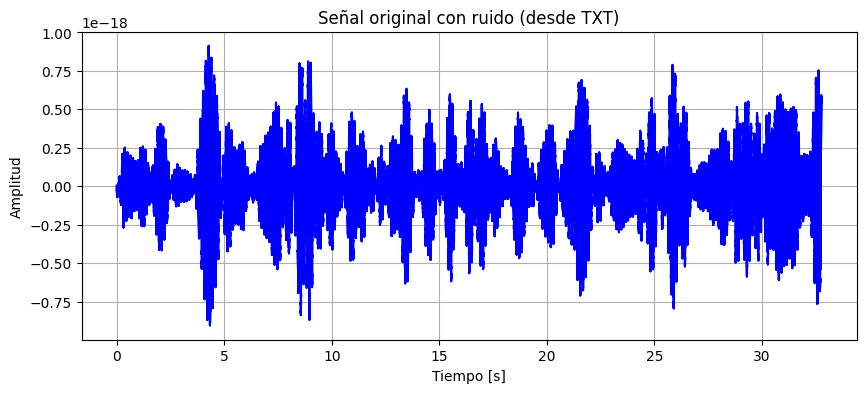

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram, butter, filtfilt, resample
from scipy.signal.windows import tukey

# Cargar datos desde archivo .txt
datos = np.loadtxt('GW190521_074359_L1.txt')

# Frecuencia original del archivo
fs = 16000  # ejemplo típico de LIGO/VIRGO

# Crear vector de tiempo
tiempo = np.linspace(0, len(datos)/fs, num=len(datos))

# Graficar señal original (ruido + chirp)
plt.figure(figsize=(10,4))
plt.plot(tiempo, datos, color='b')
plt.title('Señal original con ruido (desde TXT)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()


## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

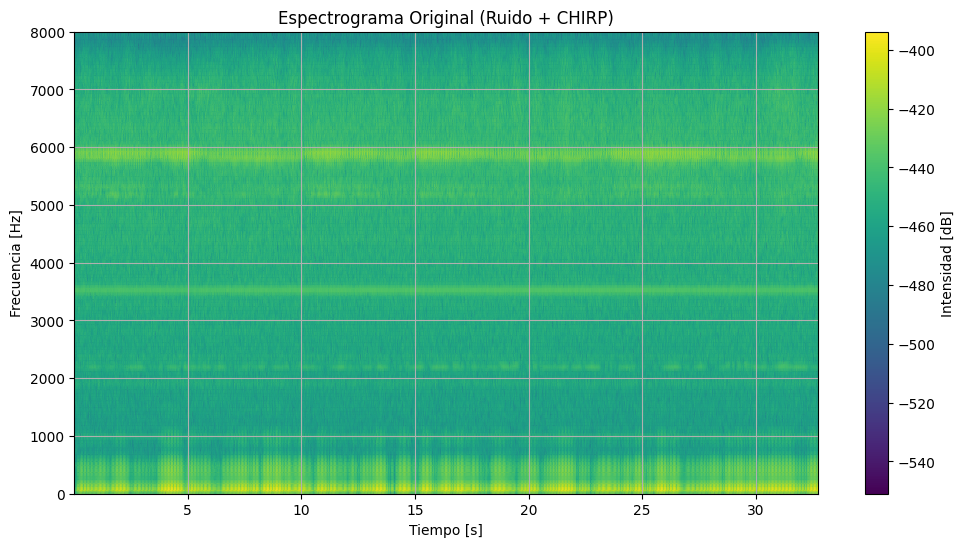

In [8]:
# Normalizar señal a formato WAV (16 bits)
datos_norm = datos / np.max(np.abs(datos))  # Normalización [-1, 1]
wavfile.write('GW190521_074359_L1_original.wav', fs, (datos_norm * 32000).astype(np.int16))


# Espectrograma original
f, t, Sxx = spectrogram(datos, fs, nperseg=256, noverlap=128)

plt.figure(figsize=(12,6))
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensidad [dB]')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma Original (Ruido + CHIRP)')
plt.grid(True)
plt.show()


## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


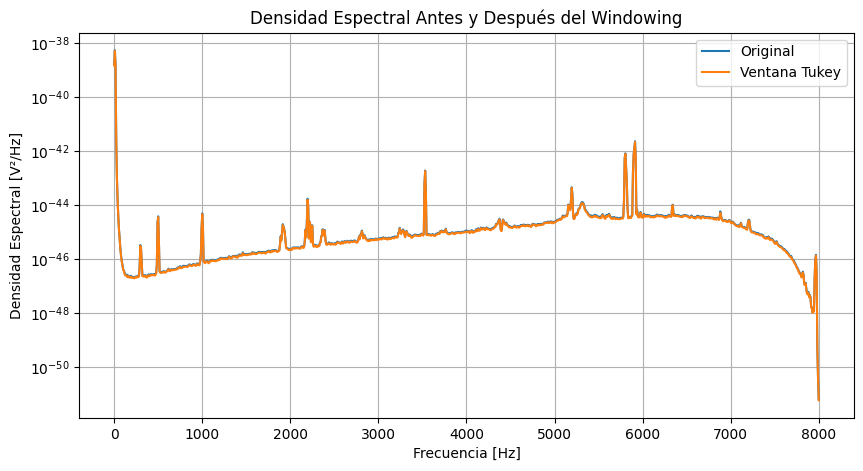

In [9]:
# Aplicar ventana Tukey
ventana = tukey(len(datos), alpha=0.1)
datos_vent = datos * ventana

# Espectro antes y después de ventana Tukey
from scipy.signal import welch
f_orig, Pxx_orig = welch(datos, fs, nperseg=2048)
f_vent, Pxx_vent = welch(datos_vent, fs, nperseg=2048)

plt.figure(figsize=(10,5))
plt.semilogy(f_orig, Pxx_orig, label='Original')
plt.semilogy(f_vent, Pxx_vent, label='Ventana Tukey')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad Espectral [V²/Hz]')
plt.title('Densidad Espectral Antes y Después del Windowing')
plt.legend()
plt.grid(True)
plt.show()


## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


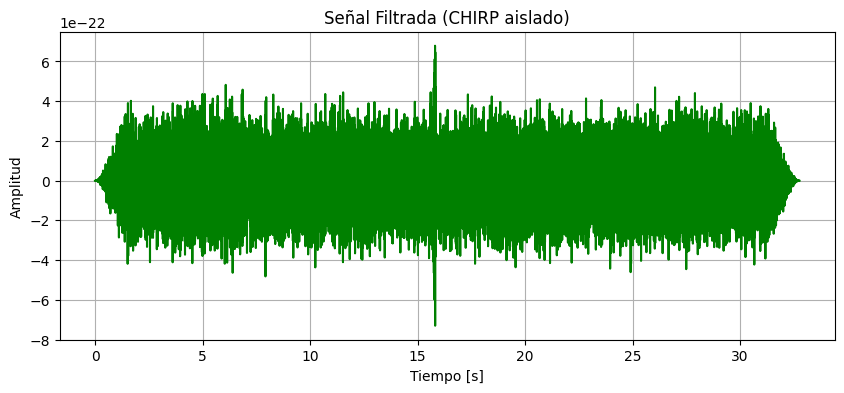

In [10]:
# Filtro pasa-banda Butterworth
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Parámetros típicos para ondas gravitacionales
lowcut = 30.0
highcut = 400.0
b, a = butter_bandpass(lowcut, highcut, fs)
datos_filtrados = filtfilt(b, a, datos_vent)

# Graficar señal filtrada
plt.figure(figsize=(10,4))
plt.plot(tiempo, datos_filtrados, color='g')
plt.title('Señal Filtrada (CHIRP aislado)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()




# Normalizar y guardar en WAV para escuchar diferencias
datos_filtrados_norm = datos_filtrados / np.max(np.abs(datos_filtrados))
wavfile.write('GW190521_074359_L1_filtrada.wav', fs, (datos_filtrados_norm * 32767).astype(np.int16))


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

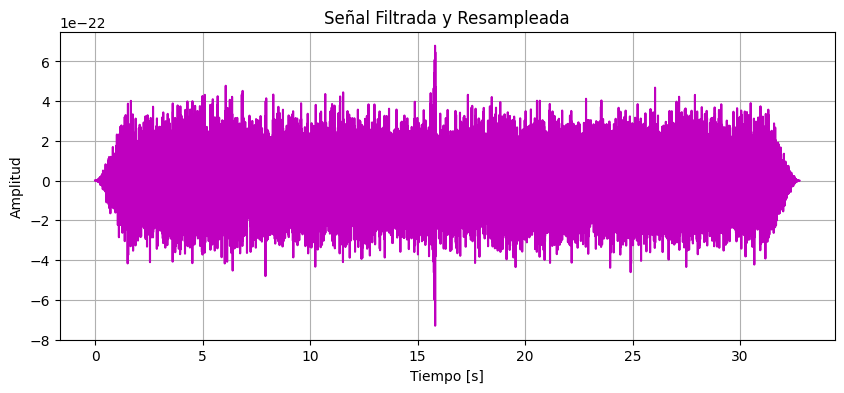

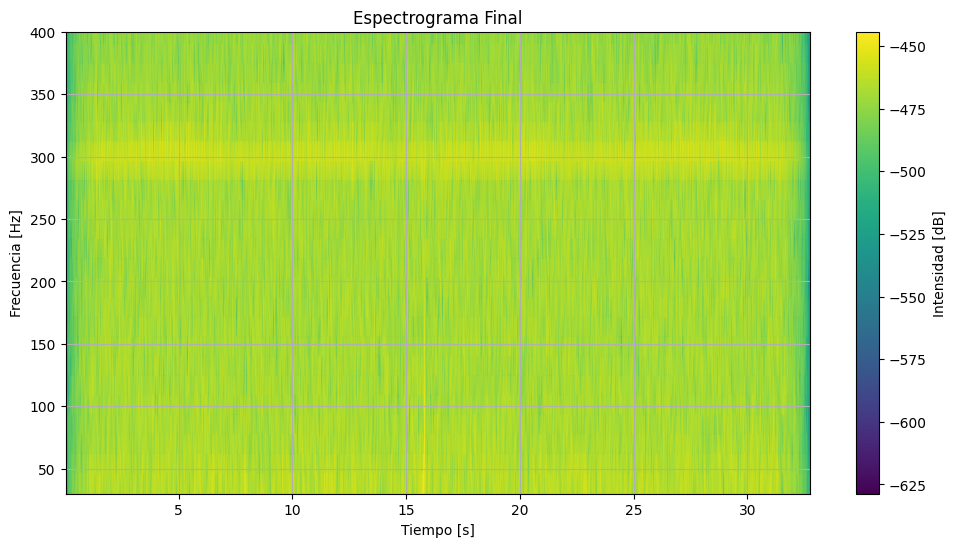

In [11]:
# Nueva frecuencia de muestreo, por ejemplo 4000 Hz
fs_nueva = 4000
nueva_longitud = int(len(datos_filtrados) * fs_nueva / fs)
datos_resampleados = resample(datos_filtrados, nueva_longitud)

tiempo_nuevo = np.linspace(0, len(datos_resampleados)/fs_nueva, num=nueva_longitud)

# Graficar señal resampleada
plt.figure(figsize=(10,4))
plt.plot(tiempo_nuevo, datos_resampleados, color='m')
plt.title('Señal Filtrada y Resampleada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# Espectrograma final
f_final, t_final, Sxx_final = spectrogram(datos_resampleados, fs_nueva, nperseg=256, noverlap=128)

plt.figure(figsize=(12,6))
plt.pcolormesh(t_final, f_final, 10*np.log10(Sxx_final), shading='gouraud')
plt.colorbar(label='Intensidad [dB]')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma Final')
plt.ylim([lowcut, highcut])  # se ajusta según filtro pasa-banda
plt.grid(True)
plt.show()

# Normalizar la señal resampleada
datos_resampleados_norm = datos_resampleados / np.max(np.abs(datos_resampleados))

# Exportar como archivo WAV
wavfile.write('GW190521_074359_L1_resampleado.wav', fs_nueva, (datos_resampleados_norm * 32767).astype(np.int16))
